In [46]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import os
import json
from matplotlib.image import imread
from scipy import optimize


In [47]:
# params
afs = ['RANDOM', 'MARGIN_SAMPLING',  'LOCALIZATION_STABILITY', \
       'MEAN_STD', 'ENTROPY', 'BALD', \
       'VAR_RATIO', 'MEAN_STD_WITH_BBOX', 'QBC']

afs_acro = {
    'RANDOM' : 'R', 
    'MARGIN_SAMPLING': 'MS',  
    'LOCALIZATION_STABILITY': 'LS', 
    'MEAN_STD': 'MSTD', 
    'ENTROPY': 'ENT', 
    'BALD': 'BALD', 
    'VAR_RATIO': 'VR', 
    'MEAN_STD_WITH_BBOX': 'MSTDB',  
    'QBC': 'QBC'
}


dropout_afs = ['RANDOM', 'MEAN_STD', 'MEAN_STD_WITH_BBOX', \
               'ENTROPY', 'BALD', 'VAR_RATIO', ]
nondropout_afs = ['RANDOM','LOCALIZATION_STABILITY', \
                  'MEAN_STD_WITH_BBOX', 'QBC']

loc_based_afs = ['RANDOM', 'MEAN_STD_WITH_BBOX', \
                 'LOCALIZATION_STABILITY', 'QBC']
nonloc_based_afs = ['RANDOM', 'MARGIN_SAMPLING',  \
                    'MEAN_STD', 'ENTROPY', 'BALD', \
                   'VAR_RATIO']

data_folder = './voc/'  # folder with data files
no_reinit_dir = './results/final_small_batch/'
reinit_dir = './results/local_weight_reinit/'

# Read data files, partition train/pool and test set
with open(os.path.join(data_folder, 'TRAIN_images.json'), 'r') as j:
    train_images = json.load(j)
with open(os.path.join(data_folder, 'TRAIN_objects.json'), 'r') as j:
    train_objects = json.load(j)
with open(os.path.join(data_folder, 'label_map.json'), 'r') as j:
    label_to_num = json.load(j)
    num_to_label = {v: k for k, v in label_to_num.items()}


# Test Accuracy vs. Acquisition Iteration



In [48]:
def plotAccuracy(afs, afs_type, results_dir, num_trials):
    plt.clf()
    for i, af in enumerate(afs):
        acc_list = []
        for i in range(1, 1+num_trials):
            file_str = results_dir + af + '_' + str(i) + '_test_acc.npy.npz'

            npzfile = np.load(file_str, allow_pickle=True)
            acc = npzfile['mAP_list']
            acc_list.append(acc)

        acc_mean = np.mean(acc_list, axis=0)
        acc_min = np.min(acc_list, axis=0)
        acc_max = np.max(acc_list, axis=0)
        min_error = acc_mean - acc_min
        max_error = acc_max - acc_mean

        x = np.linspace(1, len(acc_mean), len(acc_mean))
        plt.plot(x, acc_mean, label=afs_acro[af], marker='o',
                markersize=3, linestyle='dashed')
#         plt.errorbar(x, acc_mean, yerr=[min_error, max_error], fmt='o', label=af)

    plt.ylabel('Test set accuracy')
    plt.xlabel('Acquisition Iteration')
    plt.grid()
    # plt.title('Comparison of Various Acquisition Function')
    plt.legend(loc=0)
    plt.savefig('images/perf_plots/' + afs_type + '_img_test_set_acc.png')
    plt.show()

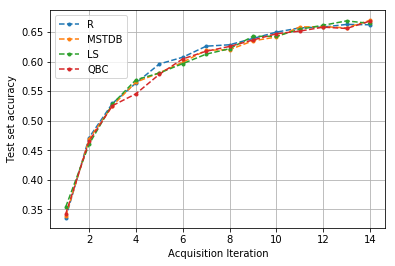

In [49]:
plotAccuracy(loc_based_afs, 'no_reinit_loc_based',
            no_reinit_dir, 3)

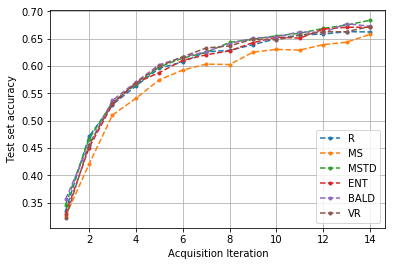

In [50]:
plotAccuracy(nonloc_based_afs, 'no_reinit_nonloc_based',
            no_reinit_dir, 3)

# Relative Savings Plot and Average Relative Savings

In [51]:
# assumes random is first in afs list
def plotRelativeSavings(afs, afs_type, results_dir, num_trials):
    af_acc_means = []
    for af in afs:
        acc_list = []
        for i in range(1, 1+num_trials):
            file_str = results_dir + af + '_' + str(i) + '_test_acc.npy.npz'

            npzfile = np.load(file_str, allow_pickle=True)
            acc = npzfile['mAP_list']
            acc_list.append(acc)
        acc_mean = np.mean(acc_list, axis=0)[:]
        af_acc_means.append(acc_mean)

    baseline_acc = af_acc_means[0]
    num_acquisition_iter = len(baseline_acc)-1
    num_images = np.linspace(500, 500 + (num_acquisition_iter*250), len(baseline_acc))
    
    
    for i, acc in enumerate(af_acc_means):
        
        #poly fit to smooth curve and ensure sequence is increasing    
        params = np.polyfit(num_images, acc, 5)
        p = np.poly1d(params)
        fitted_curve = p(num_images)

        if i==0:
            baseline_acc = fitted_curve

        rel_savings = []
        for j, mAP in enumerate(fitted_curve):
            # interpolated number of images that random acquisiton would have required
            interp = np.interp(mAP, baseline_acc, num_images)
            interp = np.round(interp)
            
            rel_saving = (interp - (500+j*250) ) / interp * 100.0
            rel_savings.append(rel_saving)

        if i == 0:
            rel_savings = np.zeros(len(acc))

        plt.plot(num_images[:-1], rel_savings[:-1], 
                 label=afs_acro[afs[i]], marker='x')
        
        name = afs[i].split('_')
        name = [n.lower() for n in name]
        name = ' '.join(name)
        avg_savings = np.round(np.mean(rel_savings), decimals=3)
        print(name + ' & ' + str(avg_savings) + '  \\\ ')
        print('\hline')
    
        
    plt.ylabel('Percentage Savings in Performance %')
    plt.xlabel('Number of Images in Random')
    plt.grid()

    # plt.title('Percentage Difference in Performance over Baseline')
    plt.legend(loc=3)
    plt.savefig('images/perf_plots/' + afs_type + '_img_rel_savings.png')

    plt.show()

random & 0.0  \\ 
\hline
mean std with bbox & -4.367  \\ 
\hline
localization stability & -1.75  \\ 
\hline
qbc & -5.824  \\ 
\hline


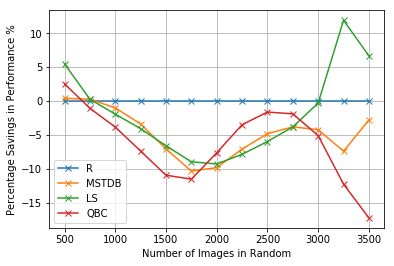

In [52]:
plotRelativeSavings(loc_based_afs, 'no_reinit_loc_based', 
                   no_reinit_dir, 3)

random & 0.0  \\ 
\hline
margin sampling & -20.814  \\ 
\hline
mean std & 6.27  \\ 
\hline
entropy & 1.255  \\ 
\hline
bald & 6.659  \\ 
\hline
var ratio & 3.584  \\ 
\hline


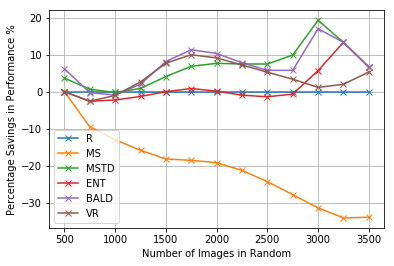

In [53]:
plotRelativeSavings(nonloc_based_afs, 'no_reinit_nonloc_based', 
                   no_reinit_dir, 3)

## Plot Test Set Accuracy Variance

In [60]:
def plotVariance(af, results_dir):
    acc_list = []
    for i in range(1, 4):
        file_str = results_dir + af + '_' + str(i) + '_test_acc.npy.npz'

        npzfile = np.load(file_str, allow_pickle=True)
        acc = npzfile['mAP_list']
        acc_list.append(acc)

    acc_mean = np.mean(acc_list, axis=0)
    acc_min = np.min(acc_list, axis=0)
    acc_max = np.max(acc_list, axis=0)
    min_error = acc_mean - acc_min
    max_error = acc_max - acc_mean
    
    x = np.linspace(1, len(acc_mean), len(acc_mean))
    
    plt.clf()
    plt.plot(x, acc_mean, label=afs_acro[af], marker='x')
    plt.fill_between(x, acc_max, acc_min, facecolor='green',alpha=0.5 )
    
    plt.ylabel('Test set accuracy')
    plt.xlabel('Acquisition Iteration')
    
    plt.grid()
    plt.show()
    plt.savefig('images/perf_plots/' + af + '_map_variation.png')


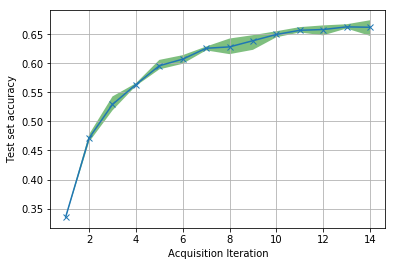

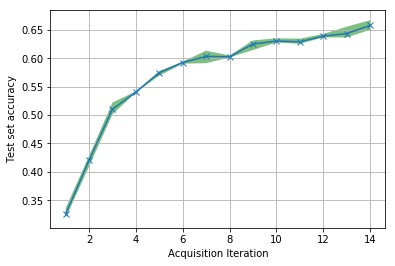

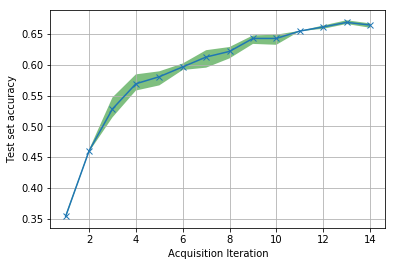

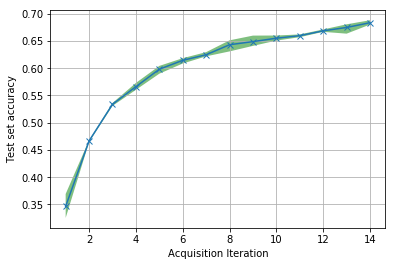

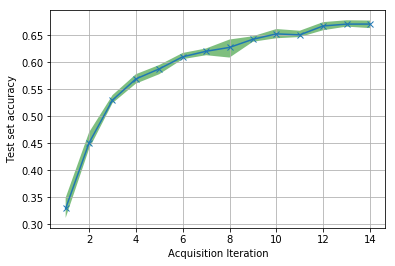

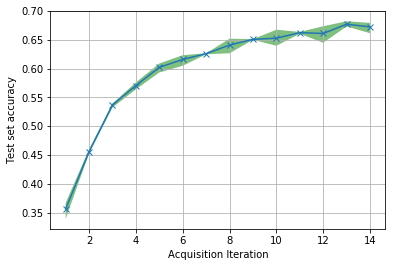

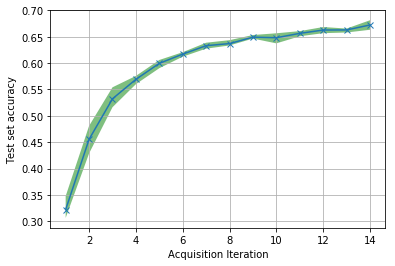

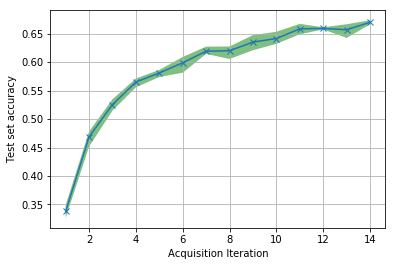

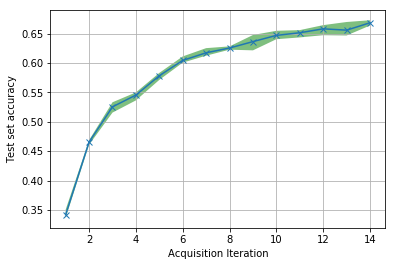

<Figure size 432x288 with 0 Axes>

In [61]:
for af in afs:
    plotVariance(af, no_reinit_dir)
# plotVariance('ENTROPY')

# Weight reinit perf

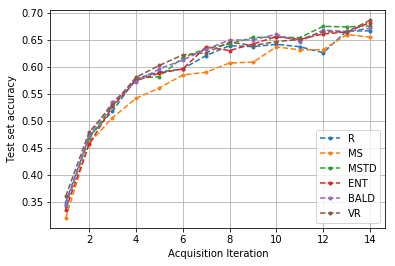

In [62]:
plotAccuracy(nonloc_based_afs, 'reinit_nonloc_based',
            reinit_dir, 1)

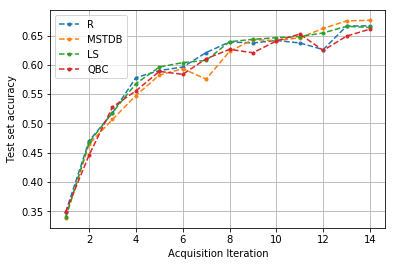

In [63]:
plotAccuracy(loc_based_afs, 'reinit_loc_based',
            reinit_dir, 1)

## Weight Reinit relative savings

random & 0.0  \\ 
\hline
mean std with bbox & -3.791  \\ 
\hline
localization stability & 3.633  \\ 
\hline
qbc & -7.843  \\ 
\hline


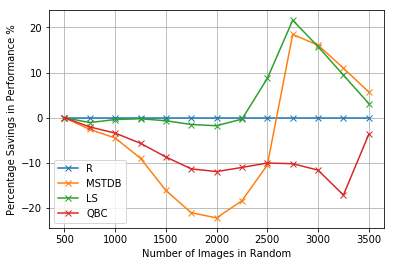

In [64]:
plotRelativeSavings(loc_based_afs, 'reinit_loc_based', 
                   reinit_dir, 1)

random & 0.0  \\ 
\hline
margin sampling & -15.928  \\ 
\hline
mean std & 9.546  \\ 
\hline
entropy & 6.198  \\ 
\hline
bald & 11.048  \\ 
\hline
var ratio & 10.555  \\ 
\hline


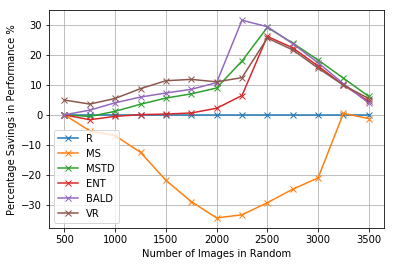

In [65]:
plotRelativeSavings(nonloc_based_afs, 'reinit_nonloc_based', 
                   reinit_dir, 1)

## log fit on accuracy

[0.35033525 0.4628349  0.52883586 0.56734501 0.59100145 0.60732249
 0.61994953 0.6298941  0.63678372 0.6401079  0.64046407 0.64080352
 0.64767737 0.67248248]
random & 0.0  \\ 
\hline
[0.32412839 0.44579152 0.51175249 0.54588691 0.56446001 0.57745652
 0.58991049 0.60323517 0.61655286 0.62802475 0.63618079 0.64124954
 0.64648802 0.65951158]
margin sampling & -15.928  \\ 
\hline
[0.34210161 0.45910177 0.52770637 0.56694315 0.59007939 0.60559702
 0.61816761 0.62962747 0.63995268 0.6482342  0.65365284 0.65645441
 0.65892471 0.66636462]
localization stability & 3.633  \\ 
\hline
[0.3447509  0.46103902 0.53068472 0.5717384  0.59681103 0.61399603
 0.62779125 0.64002087 0.65075741 0.65924359 0.66481435 0.66781872
 0.67054181 0.67812674]
mean std & 9.546  \\ 
\hline
[0.33504101 0.45729845 0.52762318 0.56745353 0.59127513 0.60790205
 0.62175776 0.63415627 0.64458312 0.65197646 0.65600812 0.6583646
 0.66402821 0.68255805]
entropy & 6.198  \\ 
\hline
[0.34593363 0.46603279 0.53534653 0.57486068 0.5

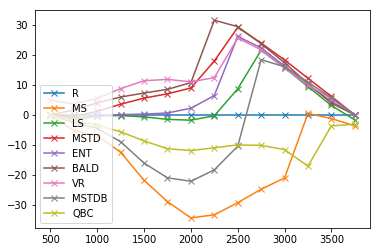

In [45]:
num_trials=1
results_dir= reinit_dir
# def plotRelativeSavings(afs, afs_type, results_dir, num_trials):
af_acc_means = []
for af in afs:
    acc_list = []
    for i in range(1, 1+num_trials):
        file_str = results_dir + af + '_' + str(i) + '_test_acc.npy.npz'

        npzfile = np.load(file_str, allow_pickle=True)
        acc = npzfile['mAP_list']
        acc_list.append(acc)
    acc_mean = np.mean(acc_list, axis=0)[:]
    af_acc_means.append(acc_mean)

baseline_acc = af_acc_means[0]
num_acquisition_iter = len(baseline_acc)-1
num_images = np.linspace(500, 500 + (num_acquisition_iter*250), len(baseline_acc))


for i, acc in enumerate(af_acc_means):
    #poly fit    
    params = np.polyfit(num_images, acc, 5)
    p = np.poly1d(params)
    fitted_curve = p(num_images)

    if i == 0:
        baseline_acc = fitted_curve
    
    rel_savings = []
    for j, mAP in enumerate(fitted_curve):

        interp = np.interp(mAP, baseline_acc, num_images)
        interp = np.round(interp)

        rel_saving = (interp - (500+j*250) ) / interp * 100.0
        rel_savings.append(rel_saving)

    if i == 0:
        rel_savings = np.zeros(len(acc))

    plt.plot(num_images, rel_savings, 
             label=afs_acro[afs[i]], marker='x')
    
    print(fitted_curve)

    name = afs[i].split('_')
    name = [n.lower() for n in name]
    name = ' '.join(name)
    avg_savings = np.round(np.mean(rel_savings), decimals=3)
    print(name + ' & ' + str(avg_savings) + '  \\\ ')
    print('\hline')

plt.legend(loc='lower left')
plt.show()

    

In [ ]:
    # log fit
#     params = np.polyfit(np.log(num_images), acc, 1)
#     fitted_curve = params[0] * np.log(num_images) + params[1]
#     plt.plot(num_images, acc,  marker='x')
#     plt.plot(num_images, fitted_curve,  marker='o')
#     plt.show()
    